<a href="https://colab.research.google.com/github/SBShimm/Datathon/blob/main/Visual_Flix_2days_SB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [161]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [162]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [163]:
! git clone https://github.com/SBShimm/Datathon.git

fatal: destination path 'Datathon' already exists and is not an empty directory.


# 1. 데이터 가져오기
#### 1) 데이터 종류

In [164]:
file_path = '/content/drive/MyDrive/Colab/Datasets/Netflix/Netflix_IMDB.csv'

data = pd.read_csv(file_path)

In [165]:
data.head()

,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,IMDB
0,0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",7.4
1,1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",6.3
2,2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,NaN
3,3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",NaN
4,4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,NaN


# 2. Data 전처리

#### 1)Data 추출

In [166]:
data['date_added'] = pd.to_datetime(data['date_added'])

In [167]:
# datetime 타입에서 년, 월, 일 추출
data['year'] = data.date_added.apply(lambda x : x.year)
data['month'] = data.date_added.apply(lambda x : x.month)
data['day'] = data.date_added.apply(lambda x : x.day)

#년월일 int로 변경
data['year'] = pd.to_datetime(data['year']).astype(np.int64)
data['month'] = pd.to_datetime(data['month']).astype(np.int64)
data['day'] = pd.to_datetime(data['day']).astype(np.int64)

data.head(3)

,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,IMDB,year,month,day
0,0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",7.4,2021,9,25
1,1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",6.3,2021,9,24
2,2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,NaN,2021,9,24


In [168]:
data.drop(data.loc[data['year']<0].index, inplace=True)

#### 2) Type 나누기, 장르세분화

In [169]:
def genere_2cols(df, col):
    
    genere_year = df[[col, 'listed_in']].value_counts()
    
    gener = {}
    
    for idx, val in genere_year.items():
        i_col = str(idx[0])
        l = idx[1].split(',')
        for i in l:
            genre_split = i.strip()
            key = i_col + ':' + genre_split
            if i in gener.keys():
                d = {}
                d[key] = val + gener[key]
                gener.update(d)
            else:
                d = {key:val}
                gener.update(d)
    cols, theme, count = [], [], []
    
    for idx, val in gener.items():
        cols.append((idx.split(':')[0]))
        theme.append(idx.split(':')[1])
        count.append(val)
    
    list_temp = (pd.DataFrame({col: cols, 'genre':theme, 'count': count})
        .sort_values('count', ascending = True))
    list_temp.reset_index(drop = True, inplace = True)
    
    return list_temp

#### 3)Country data 전처리

In [170]:
data['first_country'] = data.country.str.extract(r'([a-zA-Z\s]+)')

In [171]:
data.head()

,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,IMDB,year,month,day,first_country
0,0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",7.4,2021,9,25,United States
1,1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",6.3,2021,9,24,South Africa
2,2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,NaN,2021,9,24,NaN
3,3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",NaN,2021,9,24,NaN
4,4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,NaN,2021,9,24,India


#### 4) 별점 data (내림차순)

In [172]:
data_sort = data.sort_values(by = 'IMDB',ascending=False)

In [173]:
data_TVShow = data[data['type']=='TV Show']
data_Movie = data[data['type']=='Movie']

## 시각화

https://matplotlib.org/stable/gallery/misc/packed_bubbles.html


In [268]:
class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            font_color = 'black' if 8 <= i <= 12 else 'white'
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center',
                    color=font_color, fontsize=19)

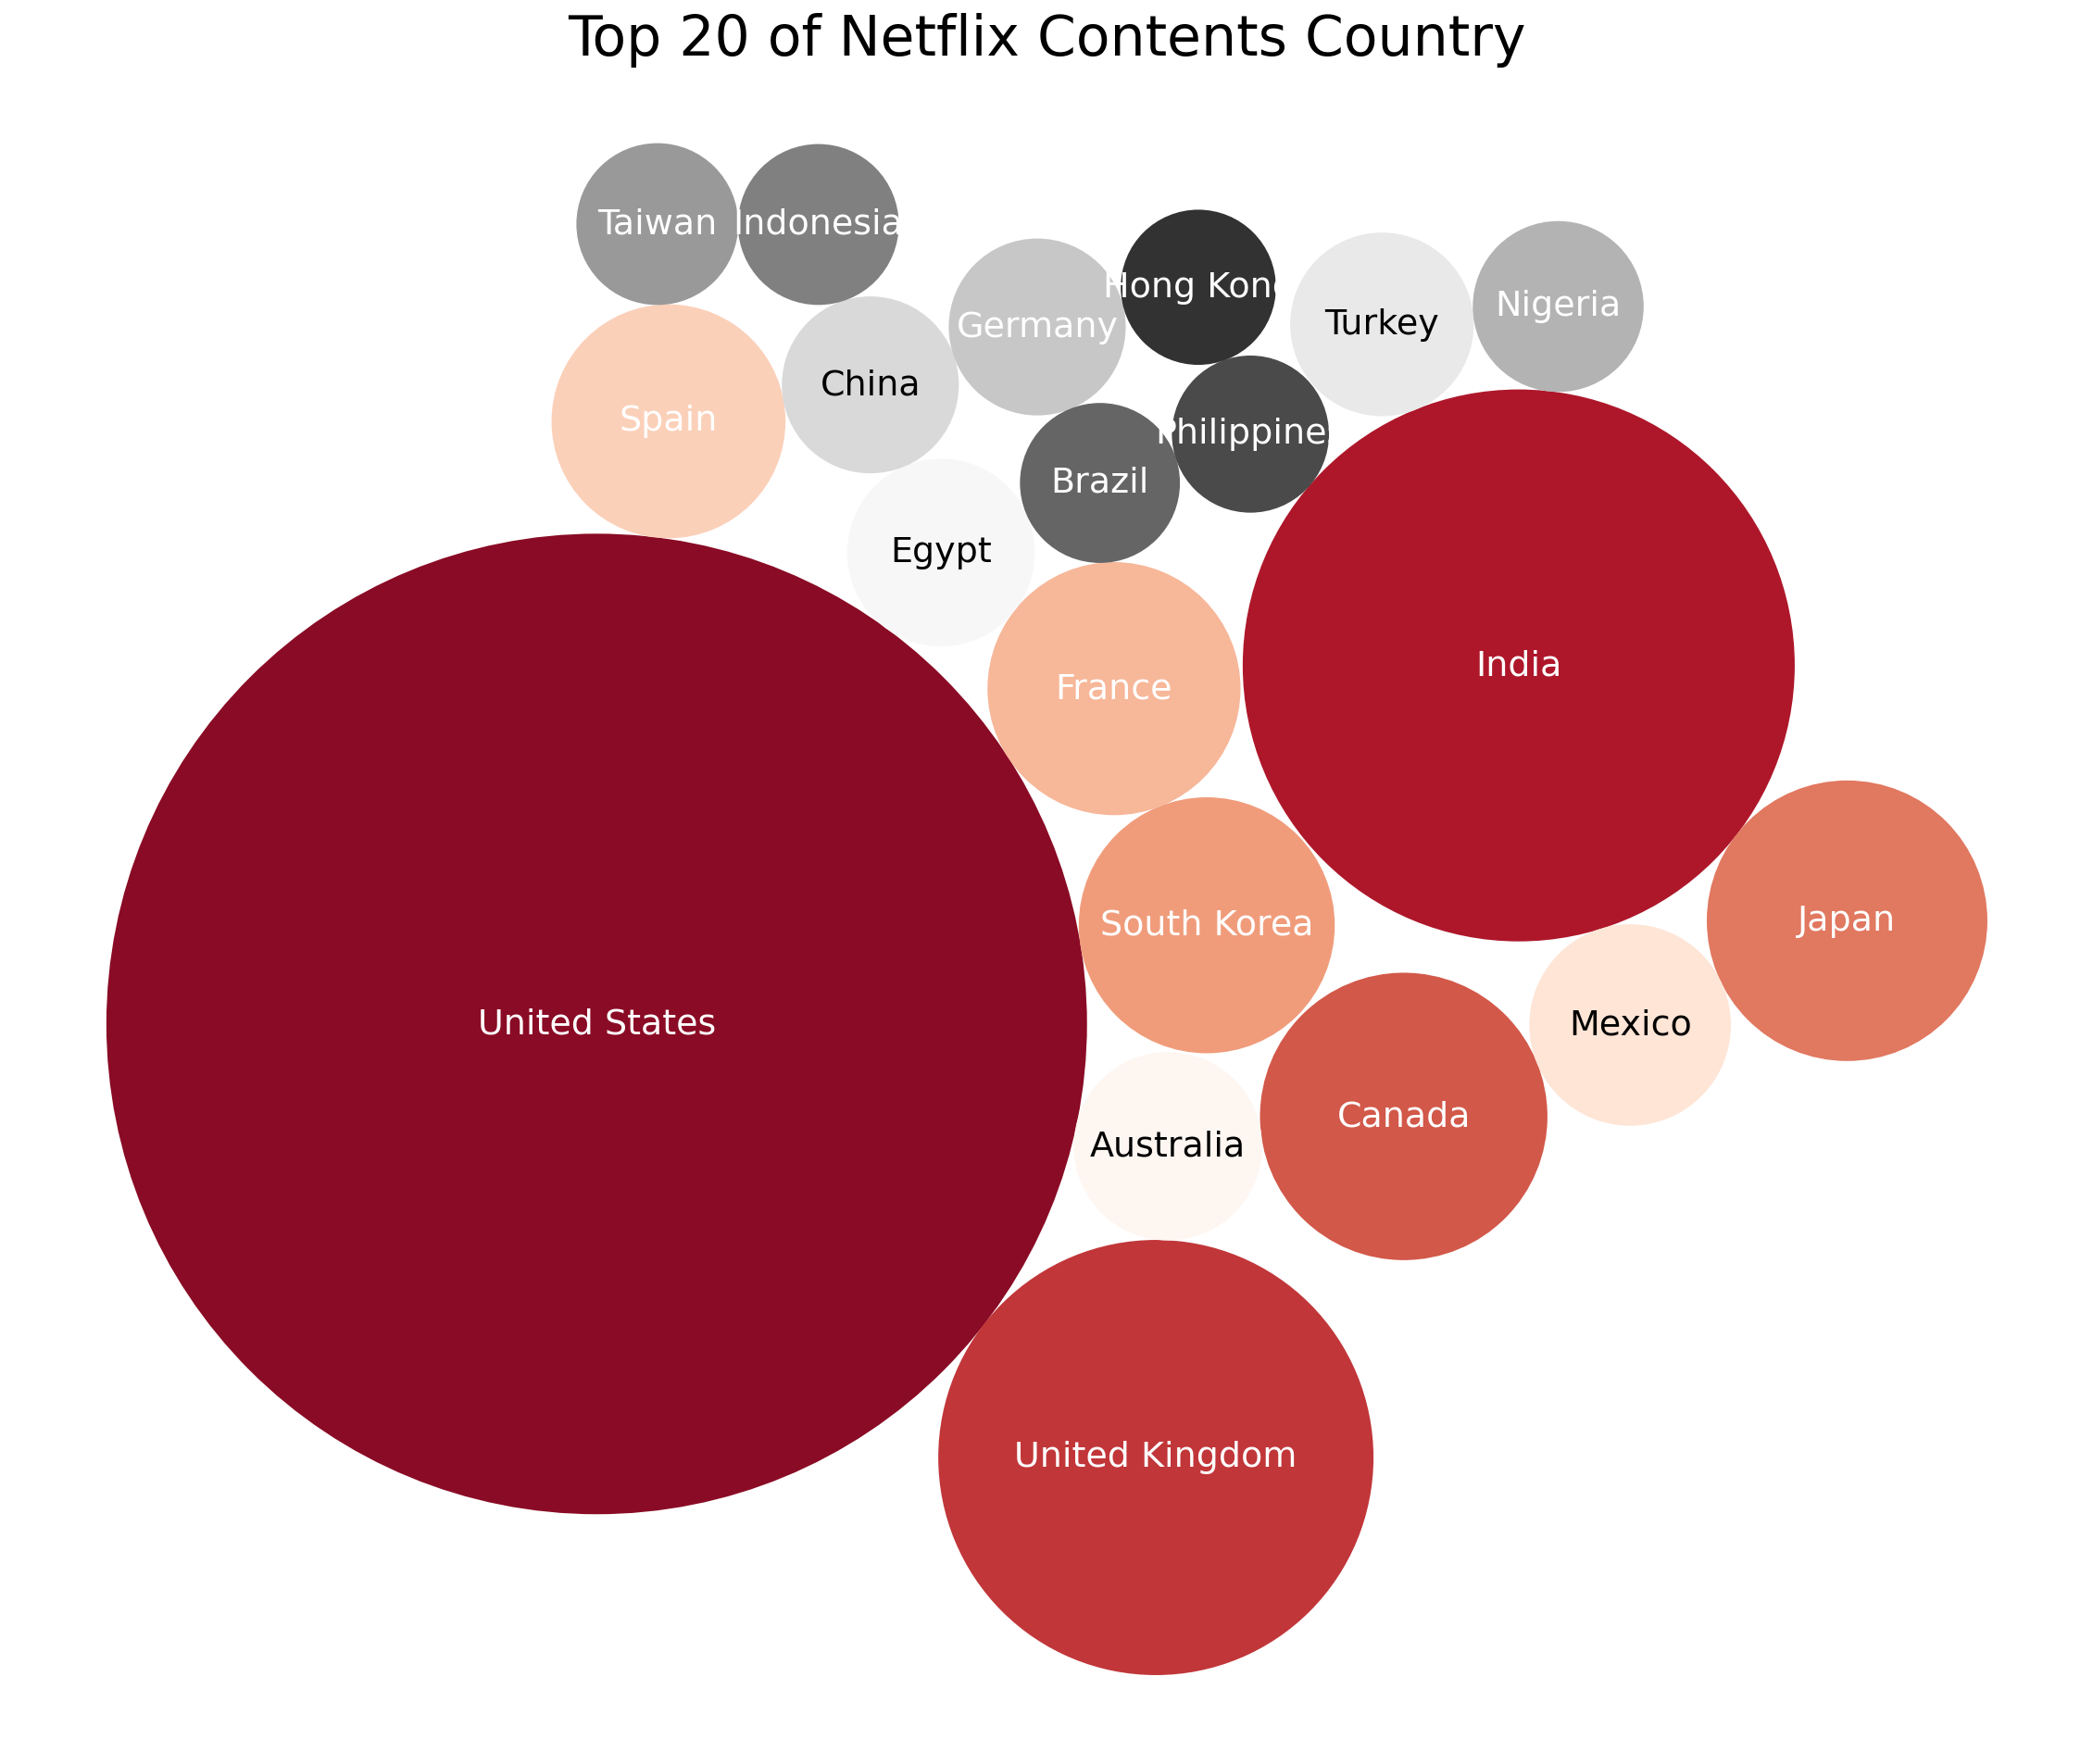

In [271]:
data_country = data['first_country'].value_counts().rename_axis('first_country').reset_index(name='counts')

bubble_chart = BubbleChart(area=data_country['counts'].head(20),
                           bubble_spacing=0.1)

bubble_chart.collapse()
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize=(20, 20))

bubble_chart.plot(
    ax, data_country['first_country'].head(20), sns.color_palette("RdGy", n_colors=20))

ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Top 20 of Netflix Contents Country', fontsize=30)

plt.show()

cchoropleth를 활용한 연도, 나라별 누적 비디오 수  
https://plotly.com/python/choropleth-maps/

In [284]:
import plotly.express as px

# 연도, 나라에 따른 count 그룹화
year_country = data.groupby('year')['first_country'].value_counts().reset_index(name='counts')

# 연도별 비는 나라 추가
all_country = year_country['first_country'].unique()
for year in range(2008, 2022):
  years_country = year_country[year_country['year']==year]['first_country'].unique()
  add_country = np.setdiff1d(all_country, years_country)
  
  for country in add_country:
    year_country = year_country.append({'year': year, 'first_country':country, 'counts':0},ignore_index=True)

# 나라별 연도에 따른 누계값 계산
year_country = year_country.sort_values(by = ['year', 'first_country'])
year_country['cnt_csum'] = year_country.groupby(['first_country'])['counts'].cumsum()
year_country.drop(year_country.loc[year_country['cnt_csum']==0].index, inplace=True)

# 그리기
fig = px.choropleth(year_country, locations="first_country", color="cnt_csum", 
                    locationmode='country names',
                    animation_frame='year',
                    range_color=[0,400],
                    color_continuous_scale=px.colors.sequential.OrRd,
                    width = 1200, height = 800)

fig.update_layout(title='Expansion of Netflix', font_size=14)
fig.plotly_relayout
fig.show()

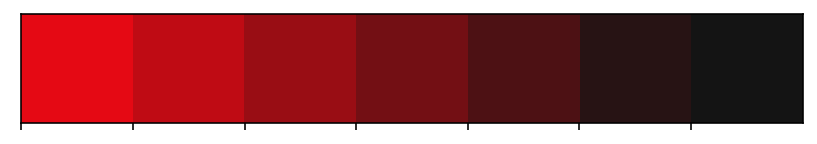

In [177]:
grad = ["#e50914", "#bf0b14", "#990d14","#730f14","#4d1114" , "#271314","#141414"]
sns.palplot(sns.color_palette(grad))
sns.set_palette(sns.color_palette(grad))

In [188]:
# 분해하여 갯수 셈
year_genre_tv = genere_2cols(data_TVShow, 'year')
year_genre_tv = year_genre_tv.sort_values(by=['year', 'genre'])
month_genre_tv = genere_2cols(data_TVShow, 'month')
month_genre_tv = month_genre_tv.sort_values(by=['month', 'genre'])

year_genre_mv = genere_2cols(data_Movie, 'year')
year_genre_mv = year_genre_mv.sort_values(by=['year', 'genre'])
month_genre_mv = genere_2cols(data_Movie, 'month')
month_genre_mv = month_genre_mv.sort_values(by=['month', 'genre'])

# 그룹별 높은 수 5개씩 추출
top_year_count_tv = year_genre_tv.groupby('year').apply(lambda x: x.nlargest(5, 'count'))
top_month_count_tv = month_genre_tv.groupby('month').apply(lambda x: x.nlargest(5, 'count'))
top_year_count_mv = year_genre_mv.groupby('year').apply(lambda x: x.nlargest(5, 'count'))
top_month_count_mv = month_genre_mv.groupby('month').apply(lambda x: x.nlargest(5, 'count'))

# index 삭제
top_year_count_tv = top_year_count_tv.droplevel(axis=0,level=0)
top_year_count_tv = top_year_count_tv.sort_values(by='year')
top_month_count_tv = top_month_count_tv.droplevel(axis=0,level=0)
top_month_count_tv = top_month_count_tv.sort_values(by='month')

top_year_count_mv = top_year_count_mv.droplevel(axis=0,level=0)
top_year_count_mv = top_year_count_mv.sort_values(by='year')
top_month_count_mv = top_month_count_mv.droplevel(axis=0,level=0)
top_month_count_mv = top_month_count_mv.sort_values(by='month')

# year, month 정수로 변환
top_year_count_tv = top_year_count_tv.astype({'year':'int'})
top_year_count_mv = top_year_count_mv.astype({'year':'int'})
top_month_count_tv = top_month_count_tv.astype({'month':'int'})
top_month_count_mv = top_month_count_mv.astype({'month':'int'})

In [293]:
import altair as alt

alt.Chart(top_year_count_mv).mark_bar().encode(
    x='year:N',
    y=alt.Y('sum(count)', stack="normalize", sort="ascending"),
    color = alt.Color("genre", scale=alt.Scale(scheme='redgrey'))).properties(
    width=900,
    height=600,
    title="Added Movie's Genre by Year").configure_title(fontSize=30)


alt.Chart(...)

In [192]:
import altair as alt

alt.Chart(top_year_count_tv).mark_bar().encode(
    x='year:N',
    y=alt.Y('sum(count)', stack="normalize", sort="ascending"),
    color = alt.Color("genre", scale=alt.Scale(scheme='redgrey'))).properties(
    width=900,
    height=600,
    title="Added TV Show's Genre by Year").configure_title(fontSize=30)


alt.Chart(...)

In [194]:
alt.Chart(top_month_count_mv).mark_bar().encode(
    x='month:N',
    y=alt.Y('sum(count)', stack="normalize", sort="ascending"),
    color = alt.Color("genre", scale=alt.Scale(scheme='redgrey'))).properties(
    width=900,
    height=600,
    title="Added Movie's Genre by Month").configure_title(fontSize=30)

alt.Chart(...)

In [294]:
alt.Chart(top_month_count_tv).mark_bar().encode(
    x='month:N',
    y=alt.Y('sum(count)', stack="normalize", sort="ascending"),
    color = alt.Color("genre", scale=alt.Scale(scheme='redgrey'))).properties(
    width=900,
    height=600,
    title="Added TV Show's Genre by Month").configure_title(fontSize=30)

alt.Chart(...)